## Setup

Import all packages we need and set the correct device. If a CUDA compatible GPU is found, it will be used. If not, everything will be done on CPU.

In [1]:
import os
import re

import math
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Handling the data

We make two classes for processing our data. The first class, TextEncoder, will be used to encode and decode text data, since we cannot use strings as input directly. All unique words will be found and mapped to an integer. Apart from the unique words we extract from the data, TextEncoder will also have an unknown token: [UNK]. This token will be used if, during inference, we encounter a word that is not part of our vocabulary.

Our second class, TextData, will handle the reading and sampling of our input data. It will use and instance of the TextEncoder class to encode our data. TextData also lets us sample sequences of text. In order to do this, TextData needs an implementation of the \_\_getitem\_\_ method, which will tell it how to handle indices. We also need a \_\_len\_\_ method so that our TextData class can work with pytorch's DataLoader, but more on that later.

All you really need to understand for now though, is that these two classes read data from a txt file and encode it so we can use it for our model.

In [2]:
class TextEncoder():
    def __init__(self, file_path):
        self.vocab = set()
        self.vocab_size = 0
        self.encoder = dict()
        self.decoder = dict()

        self._extract_vocab(file_path)
        self._make_encoder_decoder()
    
    def _extract_vocab(self, file_path):
        with open(file_path, "r") as file:
            text = file.read()
            vocab = text.split()
            # Tokenizing the text into words and cleaning each word
            vocab = [re.sub('[^A-Za-z0-9]+', '', word.lower()) for word in vocab if word != ""]
            # Creating a set to keep unique words
            vocab = set(vocab)
        # Storing vocabulary and its size (+1 for [UNK] token)
        self.vocab = vocab
        self.vocab_size = len(vocab) + 1 # add one for unknown word token

    def _make_encoder_decoder(self):
        word_ids = range(1, self.vocab_size) # reserve 0 for unknown words
        self.encoder = dict(zip(self.vocab, word_ids))
        self.decoder = dict(zip(word_ids, self.vocab))

        # add unknown token and id
        self.encoder["[UNK]"] = 0
        self.decoder[0] = "[UNK]"

class TextData(Dataset):
    def __init__(self, file_path, text_encoder, seq_len):
        super().__init__()

        self.seq_len = seq_len
        self.text_encoder = text_encoder
        self.text = self._read_text(file_path)
        self.encoded_text = self.encode_text(self.text)

    def __len__(self):
        return len(self.encoded_text) - self.seq_len - 2

    def __getitem__(self, index):
        return {
            "sequence": self.encoded_text[index : index + self.seq_len],
            "next_tokens": self.encoded_text[index + 1 : index + self.seq_len + 1],
        }

    def _read_text(self, file_path):
        with open(file_path, "r") as file:
            return file.read()
    
    def encode_text(self, text):
        all_words = text.split()
        all_words = [word.lower() for word in all_words if word != ""]
        encoded_words = [self.text_encoder.encoder[re.sub('[^A-Za-z0-9]+', '', word.lower())] if word in self.text_encoder.vocab else self.text_encoder.encoder["[UNK]"] for word in all_words]

        return np.asarray(encoded_words)

    def decode_text(self, tokens):
        sentence = []
        for token in tokens:
            #if token==0:
            #    continue
            sentence.append(self.text_encoder.decoder[token])

        return " ".join(sentence)    


## Model

Once we can process our data, we need a model. In this notebook we will train a GPT (Generative Pretrained Transformer) model with pytorch, which we define as a class here. We choose which layers we want our model to have and define the forward pass, as well as a function that generates text.

The model consists of three parts: 

<ol>
    <li> Embedding layer. This part learns vector representations for each word in the vocabulary. Additionally, it incorporates positional embeddings to retain sequential information since transformers do not inherently comprehend order.
    <li> Transformer Blocks: Constituting the core of the GPT model, these blocks contain the self-attention mechanism and multi-layer perceptrons (MLP). The self-attention mechanism enables the model to focus on different words for a given input, maintaining a contextual relationship between words in a sequence. Moreover, each block processes the input data in parallel (unlike RNNs or LSTMs), efficiently handling dependencies between words or sub-words.
    <li> Linear classifier. This is an extra layer after the Transformers blocks that makes the prediction. It outputs the logits for each word in the vocabulary, which can then be transformed into probabilities using a softmax function. The word with the highest probability can be selected as the next word in the sequence during text generation
</ol>

In [3]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
3) Taken and modified from the minimal GPT implementation: https://github.com/karpathy/nanoGPT/blob/master/model.py  
"""

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
       
        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y, att

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x_attn, attn = self.attn(self.ln_1(x))
        x = x + x_attn
        x = x + self.mlp(self.ln_2(x))
        return x, attn

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.1
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying
    
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x, attn = block(x)

        x = self.transformer.ln_f(x)

        logits = self.lm_head(x)

        # return final logits and last attention matrix of shape (B, NH, T, T)
        return logits, attn

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, sample=True, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            
            # forward the model to get the logits for the index in the sequence
            logits, attn = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            if sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                idx_next = torch.argmax(probs, dim=1).unsqueeze(0)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx, attn

## Defining functions for model training and evaluation

The most important function we're creating here is train\_loop, as this is how we train our model. The generate function is used to generate text. It is called at the end of every epoch, so we can see the model improve. The last function here is print\_model\_size, which we simply add to give you a sense of how big such a model is. If you do play around with the hyperparameters above, you can see how this influences not only the performance, but also the size. 

In [4]:
def train_loop(model, dataloader, criterion, optimizer, EPOCHS, PROMPT, LOGGING_INTERVAL=10):
    for epoch in range(EPOCHS):
        losses = []
        for i, batch in enumerate(dataloader):
            model.train()

            input_sequence = batch["sequence"].to(device)
            next_tokens = batch["next_tokens"].to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(input_sequence)

            loss = criterion(outputs.permute(0,2,1), next_tokens)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
                
        if (epoch + 1) % LOGGING_INTERVAL == 0:    
            print(f"[{epoch + 1}] train loss: {np.mean(losses):.3f}")
            sentence, _ = generate_sentence(model, dataloader, PROMPT, 32, sample=False)
            print("generated sentence: ", sentence)
                
    print("Finished training.")

def generate_sentence(model, dataloader, sentence, gen_len, temperature=0.7, sample=False):
    """
    Generate a text sequence using the trained model based on a provided starting sentence.
    
    Parameters:
        model (torch.nn.Module): The trained GPT model for text generation.
        dataloader (torch.utils.data.DataLoader): DataLoader providing access to encoding/decoding utilities.
        sentence (str): The initial seed text for generation.
        gen_len (int): The number of additional tokens to generate.
        temperature (float, optional): Controls the randomness/creativity of output; defaults to 0.7.
        sample (bool, optional): If True, samples from the output distribution; defaults to False.
    
    Returns:
        sentence (str): The generated text sequence.
        attn (torch.Tensor): Attention weights from the model's last layer.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # tokenize your prompt text, and send it to device
    x = torch.tensor(np.array([dataloader.dataset.encode_text(sentence)])).to(device)

    # Generate new token ids using the model
    generated_tokens, attn = model.generate(x, gen_len, sample=sample, temperature=temperature)
    
    # Convert the tensor of token IDs to a list and decode them into normal text
    generated_tokens = generated_tokens.view(-1).cpu().numpy().tolist()
    sentence = dataloader.dataset.decode_text(generated_tokens)

    return sentence, attn
    
def print_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement()*param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement()*buffer.element_size()

    size = (param_size + buffer_size) / 1024**2
    print("model number of params: ", sum([np.prod(p.size()) for p in model.parameters()]))
    print("model size: {:.3f}MB".format(size))

## Train your GPT!

Here we call the individual parts we defined above and actually do the training.

### Hyperparameters

Here we set some hyperparameters that will define how the model is trained. You can leave them as is or play with them and see what happens. The configurable training parameters are:
<ul>
    <li> Batch size. 
    <li> Epochs. More epochs allow the model more opportunities to learn from the data, but beware of overfitting!
    <li> Learning rate.
    <li> Sequence length. This determines the length of the sequences that the model will learn from. It's pivotal to balance: shorter sequences might lack context, while longer ones could challenge memory limits and computational efficiency.
</ul>

### Customizable Data and Prompt

You can also customize the data feed to the model and the prompt for testing the accuracy of the model.
You can change the DATA\_FILE\_PATH to any of the txt files in the Data folder, that way you can choose which data you want to train on. You can also type the PROMPT that is used to generate a sentence each epoch. Keep in mind the model will only recognize words it has seen in the txt file you train on!

We have the following txt files available:

<ul>
    <li> alice_in_wonderland.txt
    <li> dummy_text.txt
    <li> frankenstein.txt
    <li> romeo_and_juliet.txt
    <li> tolkien.txt
</ul>

### Some considerations:
<ul>
    <li> Vocabulary Awareness: The model recognizes and generates words based on its training data. Words or styles not encountered during training might be handled less adeptly.
    <li> Hyperparameter Impact: Feel free to experiment with the hyperparameters, observing how alterations influence training dynamics, model performance, and generated text quality.
    <li> Data Diversity: Different text files will immerse the model in varied linguistic environments. Observe how training on 'frankenstein.txt' might differ from 'alice_in_wonderland.txt' in influencing the model's text generation style!
    <li> Prompt Creativity: Utilize prompts to navigate the model's text generation. Observe how different prompts or seeds initiate varied continuations by the model.
</ul>

In [16]:
BATCH_SIZE = 16
EPOCHS = 1000
LEARNING_RATE = 1e-3
SEQUENCE_LEN = 32
LOGGING_INTERVAL = 10

DATA_FILE_PATH = "./Data/dummy_text.txt"
PROMPT = "contrary"

and now let's train...

In [15]:
text_encoder = TextEncoder(DATA_FILE_PATH)
dataset = TextData(DATA_FILE_PATH, text_encoder, SEQUENCE_LEN)
dataloader = DataLoader(dataset, BATCH_SIZE)
vocab_size = text_encoder.vocab_size
print(f"Number of sequences in the dataset: {len(dataloader)}")
print(f"Vocabulary size: {vocab_size}")

# Model Hyperparams
model_args = dict(n_layer=2, 
                  n_head=2, 
                  n_embd=16, 
                  block_size=SEQUENCE_LEN, # sequence length
                  bias=True, 
                  vocab_size=vocab_size, 
                  dropout=0.0) 

gpt_conf = GPTConfig(**model_args)
model = GPT(gpt_conf).to(device)

print_model_size(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), LEARNING_RATE)

train_loop(model, dataloader, criterion, optimizer, EPOCHS, PROMPT, LOGGING_INTERVAL)

Number of sequences in the dataset: 30
Vocabulary size: 256
model number of params:  11200
model size: 0.051MB
[10] train loss: 4.595
generated sentence:  lorem [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
[20] train loss: 4.579
generated sentence:  lorem [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
[30] train loss: 4.536
generated sentence:  lorem [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]
[40] train loss: 4.060
generated sentence:  lorem [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK]

KeyboardInterrupt: 

## Generating a sentence and visualizing attention

Now that we trained our model, we can play with it and generate sentences! (Again, keep in mind the model will only recognize words it has seen in the txt file you train on!). We can also visualize the attention.

### What is Attention?
In the context of transformer models like GPT, attention mechanisms are used to weigh the importance of different input tokens when predicting an output token. 

Visualizing attention weights can provide insights into the model's decision-making process. By exploring which tokens the model is focusing on when making a prediction, we can gain a better understanding of its learned patterns and potential areas of improvement.

### How are we Visualizing Attention?
In the following code, we extract the attention weights from our model and visualize them using a heatmap. The x-axis of the heatmap represents input tokens, while the color intensity represents the attention weight – darker colors indicate higher attention.

<ul>
    <li> Token Selection. We select a token of interest in a sentence and inspect how much attention it pays to other tokens when being predicted.
    <li> Head Selection. Transformers contain multiple attention heads, each learning different patterns of attention. We select one of these heads for visualization.
    <li> Heatmap. The heatmap represents attention weights from one token (e.g., "gandalf") towards all preceding tokens in the sentence.
</ul>

In [17]:
PROMPT = "Lorem"
sentence, attn = generate_sentence(model, dataloader, PROMPT, 16, temperature=0.8, sample=True)
sentence = sentence.split(" ")
print(sentence)

['lorem', 'ipsum', '[UNK]', 'and', 'going', 'through', 'the', 'cites', 'of', 'the', 'word', 'in', 'classical', '[UNK]', 'discovered', 'the', 'undoubtable']


In [18]:
%matplotlib inline

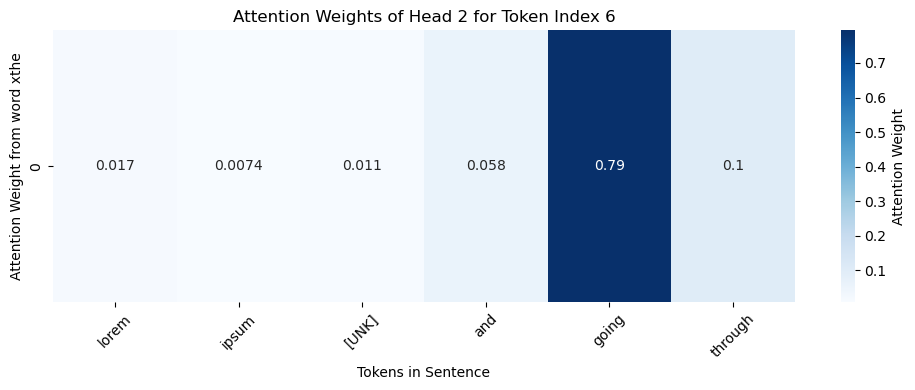

In [19]:
# Now, attn_weights is of shape (1, model.n_head, T, T)
# We get attention weights for our token of interest for the specified head
token_idx = 6 #sentence.index('flying')
head = 1

attention = attn[0, head, token_idx].cpu().detach().numpy()
attention = attention[:token_idx]

# Convert the 1D vector to a 2D matrix and transpose for horizontal heatmap
attention_matrix = attention.reshape(1, -1)

# Now we'll plot the attention weights using a heatmap
plt.subplots(figsize=(10, 4))
sns.heatmap(attention_matrix, cmap="Blues", annot=True, xticklabels=sentence[:token_idx], cbar_kws={'label': 'Attention Weight'})
#sns.heatmap(attention_matrix, cmap="Blues", cbar_kws={'label': 'Attention Weight'}, ax=ax, annot=True)


plt.ylabel(f'Attention Weight from word x{sentence[token_idx]}')
plt.xlabel('Tokens in Sentence')
plt.title(f'Attention Weights of Head {head+1} for Token Index {token_idx}')
plt.xticks(rotation=45)  # Rotate token names diagonally for better visibility
plt.tight_layout()  # Ensures that everything fits without overlap
plt.show()